# [모듈 2.1] Bank Fruad 데이터 준비, XGBoost 훈련 및 평가

### [알림] <font coler="red"> conda_python3 커널 </font> 과 함께 사용해야 합니다.

* 이 노트북은 `0.1.Install_Package` 반드시 먼저 실행해야 합니다.

### 데이터 셋 참고:
- Synthetic Financial Datasets For Fraud Detection
    - https://www.kaggle.com/ealaxi/paysim1
- Kaggle 에서 데이터 다운로드 방법
    - https://github.com/mullue/amazon-sagemaker-architecting-for-ml/blob/master/Starter-Code-kr/How_to_downlaod_kaggle_data/0.download_kaggle_dataset.ipynb


# 0. 환경 셋업

In [12]:
import pandas as pd
pd.set_option("display.max_columns", 500)

import numpy as np
import matplotlib.pyplot as plt
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")


import sagemaker
from sagemaker import get_execution_role

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = "ml_data_prep_workshop/xgboost-bankfraud"
role = get_execution_role()

파이썬 라이브러리를 로딩시에 재로딩을 하는 코드 입니다.

In [2]:
%load_ext autoreload
%autoreload 2

# 1. 데이타 준비

In [3]:
fraud = pd.read_csv('data/PS_20174392719_1491204439457_log.csv')
fraud

step      type      amount     nameOrig  oldbalanceOrg  \
0           1   PAYMENT     9839.64  C1231006815      170136.00   
1           1   PAYMENT     1864.28  C1666544295       21249.00   
2           1  TRANSFER      181.00  C1305486145         181.00   
3           1  CASH_OUT      181.00   C840083671         181.00   
4           1   PAYMENT    11668.14  C2048537720       41554.00   
...       ...       ...         ...          ...            ...   
6362615   743  CASH_OUT   339682.13   C786484425      339682.13   
6362616   743  TRANSFER  6311409.28  C1529008245     6311409.28   
6362617   743  CASH_OUT  6311409.28  C1162922333     6311409.28   
6362618   743  TRANSFER   850002.52  C1685995037      850002.52   
6362619   743  CASH_OUT   850002.52  C1280323807      850002.52   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
0             160296.36  M1979787155            0.00            0.00        0   
1              19384.72  M2044282225            0.00            0.00        0   
2                  0.00   C553264065            0.00            0.00        1   
3                  0.00    C38997010        21182.00            0.00        1   
4              29885.86  M1230701703            0.00            0.00        0   
...                 ...          ...             ...             ...      ...   
6362615            0.00   C776919290            0.00       339682.13        1   
6362616            0.00  C1881841831            0.00            0.00        1   
6362617            0.00  C1365125890        68488.84      6379898.11        1   
6362618            0.00  C2080388513            0.00            0.00        1   
6362619            0.00   C873221189      6510099.11      7360101.63        1   

         isFlaggedFraud  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
...                 ...  
6362615               0  
6362616               0  
6362617               0  
6362618               0  
6362619               0  

[6362620 rows x 11 columns]

###  레이블 컬럼을 숫자형으로 변경 혹은 유지

레이블 컬럼이 숫자형으로 1, 0 이면 데이터 프레임의 가장 앞에 위치 시킴.
이유는 "상관 계수 분석시" 에 레이블 컬럼도 포함시기키 위함 입니다.

In [4]:
from src.tabular_utils import change_y

#    isChange 이면 레이블 컬럼을 데이터 프레임의 가장 맨 앞에 위치 함.
#    그렇지 않으면 'True.' --> 1 로 바꾸고, 아니면 0으로 합니다.
fraud = change_y(fraud, col='isFraud', isChange=False)
fraud

isFraud  step      type      amount     nameOrig  oldbalanceOrg  \
0              0     1   PAYMENT     9839.64  C1231006815      170136.00   
1              0     1   PAYMENT     1864.28  C1666544295       21249.00   
2              1     1  TRANSFER      181.00  C1305486145         181.00   
3              1     1  CASH_OUT      181.00   C840083671         181.00   
4              0     1   PAYMENT    11668.14  C2048537720       41554.00   
...          ...   ...       ...         ...          ...            ...   
6362615        1   743  CASH_OUT   339682.13   C786484425      339682.13   
6362616        1   743  TRANSFER  6311409.28  C1529008245     6311409.28   
6362617        1   743  CASH_OUT  6311409.28  C1162922333     6311409.28   
6362618        1   743  TRANSFER   850002.52  C1685995037      850002.52   
6362619        1   743  CASH_OUT   850002.52  C1280323807      850002.52   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  \
0             160296.36  M1979787155            0.00            0.00   
1              19384.72  M2044282225            0.00            0.00   
2                  0.00   C553264065            0.00            0.00   
3                  0.00    C38997010        21182.00            0.00   
4              29885.86  M1230701703            0.00            0.00   
...                 ...          ...             ...             ...   
6362615            0.00   C776919290            0.00       339682.13   
6362616            0.00  C1881841831            0.00            0.00   
6362617            0.00  C1365125890        68488.84      6379898.11   
6362618            0.00  C2080388513            0.00            0.00   
6362619            0.00   C873221189      6510099.11      7360101.63   

         isFlaggedFraud  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
...                 ...  
6362615               0  
6362616               0  
6362617               0  
6362618               0  
6362619               0  

[6362620 rows x 11 columns]

# 2. 데이터 프로파일링

- pandas_profiling 패키지를 통해서 기본적인 데이터 탐색 및 권고 사항을 알려 줍니다.
- 약 2분 정도 소요 됩니다.

#### 참고
- 공식 페이지 --> [pandas_profiling](https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/)

In [5]:
%%time

import pandas_profiling as pp
pp.ProfileReport(fraud)

CPU times: user 567 ms, sys: 87.6 ms, total: 655 ms
Wall time: 683 ms


Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 데이터 프로파일링 분석
- State, Phone 은 High Cardinality 로 피쳐 제외 권고
- Phone 제외시에 지역 코드인 Area Code 도 제외 필요.


![fraud_profile_warning.png](img/fraud_profile_warning.png)

## 상관 계수 분석
- 연관된 변수의 삭제를 위하여 상관 계수 분석 합니다.
- `threshold = 0.7` 기준하에 'Day Mins' 와 'Eve Charge' 가 하이라이트 됨.
    - 보통 0.9 이상이 되면 삭제를 하지만, 여기서는 예시로서 'Eve Charge' 를 삭제 하겠습니다.


In [6]:
#threshold = 0.9
threshold = 0.7


def highlight(value):
    if value > threshold:
        style = 'background-color: pink;color: black'        
    else:
        style = 'background-color: palegreen;color: black'        
    return style

# Absolute value correlation matrix
corr_matrix = fraud.corr().abs().round(2)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.style.format("{:.2f}").applymap(highlight)

In [7]:
fraud

isFraud  step      type      amount     nameOrig  oldbalanceOrg  \
0              0     1   PAYMENT     9839.64  C1231006815      170136.00   
1              0     1   PAYMENT     1864.28  C1666544295       21249.00   
2              1     1  TRANSFER      181.00  C1305486145         181.00   
3              1     1  CASH_OUT      181.00   C840083671         181.00   
4              0     1   PAYMENT    11668.14  C2048537720       41554.00   
...          ...   ...       ...         ...          ...            ...   
6362615        1   743  CASH_OUT   339682.13   C786484425      339682.13   
6362616        1   743  TRANSFER  6311409.28  C1529008245     6311409.28   
6362617        1   743  CASH_OUT  6311409.28  C1162922333     6311409.28   
6362618        1   743  TRANSFER   850002.52  C1685995037      850002.52   
6362619        1   743  CASH_OUT   850002.52  C1280323807      850002.52   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  \
0             160296.36  M1979787155            0.00            0.00   
1              19384.72  M2044282225            0.00            0.00   
2                  0.00   C553264065            0.00            0.00   
3                  0.00    C38997010        21182.00            0.00   
4              29885.86  M1230701703            0.00            0.00   
...                 ...          ...             ...             ...   
6362615            0.00   C776919290            0.00       339682.13   
6362616            0.00  C1881841831            0.00            0.00   
6362617            0.00  C1365125890        68488.84      6379898.11   
6362618            0.00  C2080388513            0.00            0.00   
6362619            0.00   C873221189      6510099.11      7360101.63   

         isFlaggedFraud  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
...                 ...  
6362615               0  
6362616               0  
6362617               0  
6362618               0  
6362619               0  

[6362620 rows x 11 columns]

## 피쳐 제거
- "데이터 프로 파일링 분석" 과 "상관 계수 분석" 에 기반하여 아래 컬럼을 삭제 합니다.

In [8]:
drop_cols = ['step','isFlaggedFraud','nameOrig','nameDest']
fraud_cl = fraud.drop(columns=drop_cols)
fraud_cl

isFraud      type      amount  oldbalanceOrg  newbalanceOrig  \
0              0   PAYMENT     9839.64      170136.00       160296.36   
1              0   PAYMENT     1864.28       21249.00        19384.72   
2              1  TRANSFER      181.00         181.00            0.00   
3              1  CASH_OUT      181.00         181.00            0.00   
4              0   PAYMENT    11668.14       41554.00        29885.86   
...          ...       ...         ...            ...             ...   
6362615        1  CASH_OUT   339682.13      339682.13            0.00   
6362616        1  TRANSFER  6311409.28     6311409.28            0.00   
6362617        1  CASH_OUT  6311409.28     6311409.28            0.00   
6362618        1  TRANSFER   850002.52      850002.52            0.00   
6362619        1  CASH_OUT   850002.52      850002.52            0.00   

         oldbalanceDest  newbalanceDest  
0                  0.00            0.00  
1                  0.00            0.00  
2                  0.00            0.00  
3              21182.00            0.00  
4                  0.00            0.00  
...                 ...             ...  
6362615            0.00       339682.13  
6362616            0.00            0.00  
6362617        68488.84      6379898.11  
6362618            0.00            0.00  
6362619      6510099.11      7360101.63  

[6362620 rows x 7 columns]

## 카테고리 변수의 이진 변수 (One-Hot Encoding) 변환
- XGBoost 알고리즘은 카테고리 변수를 사용할 수 없어서, 이진 숫자형의 값으로 변환 합니다. (0 혹은 1)

In [10]:
def get_dummy_df(df, prefix, col):
    ldf = df.copy()
    one_hot = pd.get_dummies(ldf[col], prefix=prefix)
    ldf.drop(columns=col, inplace=True)
    ldf = pd.concat([ldf, one_hot], axis=1)
    
    
    return ldf

fraud_cl = get_dummy_df(fraud_cl, prefix='type', col='type')
fraud_cl



isFraud      amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0              0     9839.64      170136.00       160296.36            0.00   
1              0     1864.28       21249.00        19384.72            0.00   
2              1      181.00         181.00            0.00            0.00   
3              1      181.00         181.00            0.00        21182.00   
4              0    11668.14       41554.00        29885.86            0.00   
...          ...         ...            ...             ...             ...   
6362615        1   339682.13      339682.13            0.00            0.00   
6362616        1  6311409.28     6311409.28            0.00            0.00   
6362617        1  6311409.28     6311409.28            0.00        68488.84   
6362618        1   850002.52      850002.52            0.00            0.00   
6362619        1   850002.52      850002.52            0.00      6510099.11   

         newbalanceDest  type_CASH_IN  type_CASH_OUT  type_DEBIT  \
0                  0.00             0              0           0   
1                  0.00             0              0           0   
2                  0.00             0              0           0   
3                  0.00             0              1           0   
4                  0.00             0              0           0   
...                 ...           ...            ...         ...   
6362615       339682.13             0              1           0   
6362616            0.00             0              0           0   
6362617      6379898.11             0              1           0   
6362618            0.00             0              0           0   
6362619      7360101.63             0              1           0   

         type_PAYMENT  type_TRANSFER  
0                   1              0  
1                   1              0  
2                   0              1  
3                   0              0  
4                   1              0  
...               ...            ...  
6362615             0              0  
6362616             0              1  
6362617             0              0  
6362618             0              1  
6362619             0              0  

[6362620 rows x 11 columns]

# 3. 데이터 세트 분리
- 전체 데이타를 8:1:1 의 비율로 훈련, 검증, 테스트 데이터 셋으로 분리 합니다.
- 훈련과 검증 데이터는 CSV 데이터로 로컬에 저장 합니다.

In [11]:
train_data, validation_data, test_data = np.split(
    fraud_cl.sample(frac=1, random_state=1024),
    [int(0.8 * len(fraud_cl)), int(0.9 * len(fraud_cl))],
)
train_data.to_csv("train.csv", header=True, index=False)
validation_data.to_csv("validation.csv", header=True, index=False)

## 로컬의 데이터를 S3에 업로딩

In [13]:
import sagemaker

sess = sagemaker.Session()
training = sess.upload_data(path="train.csv", key_prefix=prefix + "/training")
validation = sess.upload_data(path="validation.csv", key_prefix=prefix + "/validation")
print(training)
print(validation)  



s3://sagemaker-ap-northeast-2-057716757052/ml_data_prep_workshop/xgboost-bankfraud/training/train.csv
s3://sagemaker-ap-northeast-2-057716757052/ml_data_prep_workshop/xgboost-bankfraud/validation/validation.csv


# 4. SageMaker 모델  훈련

In [14]:
# train_instance_type = 'local'
train_instance_type = 'ml.m4.16xlarge'

from sagemaker.xgboost import XGBoost

xgb_estimator = XGBoost(entry_point='train_xgb.py', 
                        source_dir = 'src',
                        role=role,
                        train_instance_count=1, 
                        train_instance_type= train_instance_type,
                        framework_version='0.90-2',
                        py_version='py3',
                        hyperparameters={
                              'label_column' : 'isFraud',
                              'max-depth': 5,
                              'eval-metric': 'auc',
                          }
                       )  

train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [15]:
%%time
xgb_estimator.fit({'training':training, 'validation':validation},
                  wait=True,
                 )

2021-12-31 06:45:06 Starting - Starting the training job...
2021-12-31 06:45:29 Starting - Launching requested ML instancesProfilerReport-1640933106: InProgress
...
2021-12-31 06:46:02 Starting - Preparing the instances for training............
2021-12-31 06:48:03 Downloading - Downloading input data
2021-12-31 06:48:03 Training - Downloading the training image...
2021-12-31 06:48:30 Training - Training image download completed. Training in progress.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Invoking user training script.
INFO:sagemaker-containers:Module train_xgb does not provide a setup.py. 
Generating setup.py
INFO:sagemaker-containers:Generating setup.cfg
INFO:sagemaker-containers:Generating MANIFEST.in
INFO:sagemaker-containers:Installing module with the following command:
/miniconda3/bin/python3 -m pip install . 
Processing /opt

# 5. 모델 다운로드 및 평가



## 모델 가중치 다운로드 및 압축 해제

In [18]:
import pickle
import tarfile
sagemaker.s3.S3Downloader().download(xgb_estimator.model_data, ".")

tfile = tarfile.open("model.tar.gz")
tfile.extractall(".")

## 모델 가중치 로딩
- S3로 부터 다운로드 받은 가중치를 XGBoost 모델로 로딩 합니다.

In [19]:
import os, argparse, pickle
import xgboost as xgb
import pandas as pd

print("XGBoost", xgb.__version__)


def model_fn(model_dir):
    model = xgb.Booster()
    model.load_model(os.path.join(model_dir, 'xgb.model'))
    return model

xgb_model = model_fn(model_dir=".")

XGBoost 1.4.2
[07:09:12] WARNING: ../src/learner.cc:851: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


## 훈련 및 테스트 데이터 준비
- 모델 검증을 위해서는 테스트 데이터만 평가하면 되나, 훈련 데이터와 상호 비교를 위해서 훈련 데이터도 준비 합니다.

In [20]:
train_data # , validation_data test_data
label_name = 'isFraud'

y_train = train_data[label_name]
X_train = train_data.drop(columns=[label_name])


y_test = test_data[label_name]
X_test = test_data.drop(columns=[label_name])

DMatrix 형태로 추론을 하기 위한 포맷으로 변경 합니다.

In [21]:
from src.tabular_utils import get_binary_prediction, plot_cm2

payload_train = xgb.DMatrix(X_train)
payload_test = xgb.DMatrix(X_test)


## 훈련 데이터와 테스트 데이터로 추론

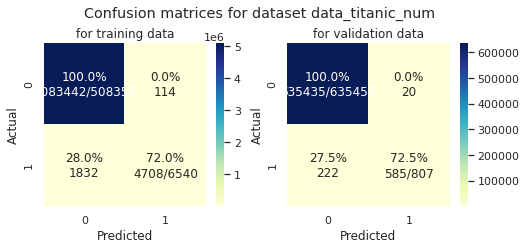

In [22]:
train_pred_prob = xgb_model.predict(payload_train)
train_pred = get_binary_prediction(train_pred_prob, threshold=0.5)

test_pred_prob = xgb_model.predict(payload_test)
test_pred = get_binary_prediction(test_pred_prob, threshold=0.5)

plot_cm2(y_train, train_pred, y_test, test_pred, "Confusion matrices for dataset data_titanic_num", figsize=(8,3))

## 분류 결과 리포트 및 ROC_AUC 커브 

Classification report for training data
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083556
           1       0.98      0.72      0.83      6540

    accuracy                           1.00   5090096
   macro avg       0.99      0.86      0.91   5090096
weighted avg       1.00      1.00      1.00   5090096

Classification report for validation data
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    635455
           1       0.97      0.72      0.83       807

    accuracy                           1.00    636262
   macro avg       0.98      0.86      0.91    636262
weighted avg       1.00      1.00      1.00    636262



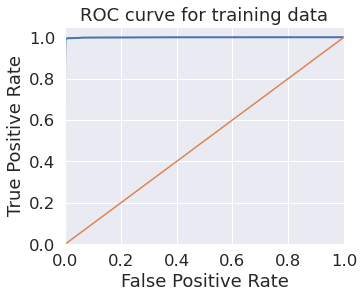

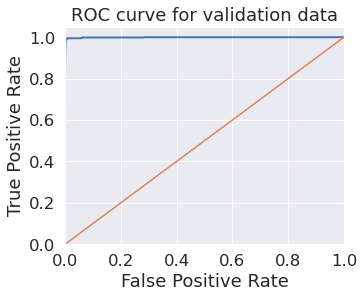

In [23]:
from src.tabular_utils import roc_auc_plot

roc_auc_plot(xgb_model, payload_train, y_train, payload_test, y_test)

# 5. 훈련 모델 분석 (SHAP)

## 훈련 데이터 셋 분석

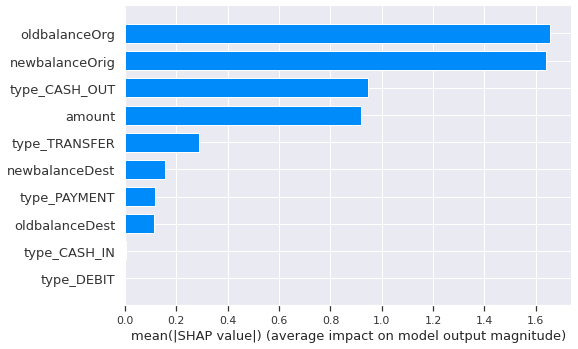

In [24]:
import shap

shap_values = shap.TreeExplainer(xgb_model).shap_values(X_train)
# shap_interaction_values = shap.TreeExplainer(xgb_model).shap_interaction_values(Xval)
shap.summary_plot(shap_values, X_train, plot_type="bar")

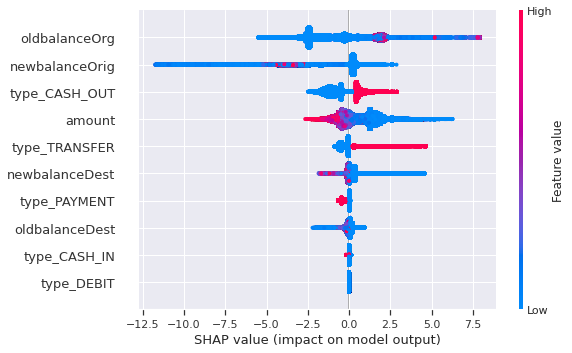

In [25]:
shap_values = shap.TreeExplainer(xgb_model).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

In [26]:
from src.tabular_utils import data_force_plot_n

In [27]:
data_force_plot_n(xgb_model, X_train)

## 테스트 데이터 셋 분석

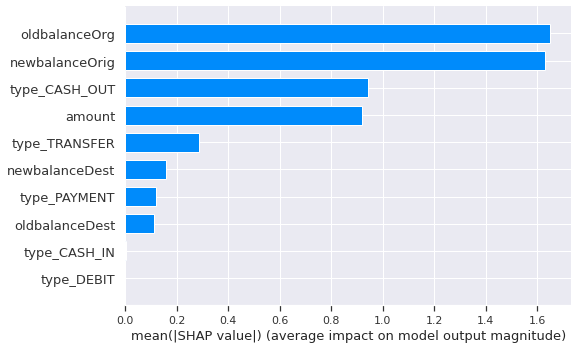

In [28]:
shap_values = shap.TreeExplainer(xgb_model).shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

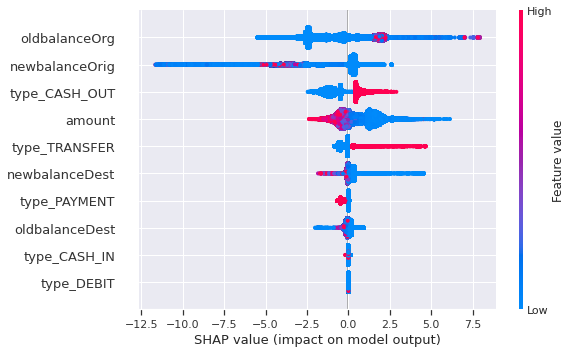

In [29]:
shap_values = shap.TreeExplainer(xgb_model).shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [30]:
data_force_plot_n(xgb_model, X_test)